In [3]:
%load_ext autoreload
%autoreload 2
import torch
from torch.nn import functional as F
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
from omegaconf import OmegaConf
import pytorch_lightning as pl
import torchvision.models as models

from brainage.model.agemodel_2dslices import AgeModel2DSlices
from brainage.dataset.dataset2d import SliceDataset

In [214]:
#ckpt = '/is/ei/thepp/projects/brainage/outputs/2020-07-15/16-46-42/my-project/2khe2txe/checkpoints/epoch=25.ckpt'
ckpt = '/is/ei/thepp/projects/brainage/outputs/2020-07-15/21-13-52/my-project/30zz7v96/checkpoints/epoch=77.ckpt'

In [215]:
model = AgeModel2DSlices.load_from_checkpoint(ckpt, train_ds=None, val_ds=None)
model.eval()

AgeModel2DSlices(
  (net): ResNet(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, trac

In [216]:
cfg = OmegaConf.load('../../config/config.yaml')

In [217]:
with Path(cfg.dataset.val).open('r') as f:
    val_keys = [l.strip() for l in f.readlines()]

info_df = pd.read_feather(cfg.dataset.info)
info_df = info_df[(info_df['slice']>55) & (info_df['slice']<57)]
info_val = info_df[info_df.key.isin(val_keys)]
ds_val = SliceDataset(cfg.dataset.data, 
                      info=info_val, preload=cfg.dataset.preload)

loading data to memory ...
finished 53.48 MB - 3.12s 


59


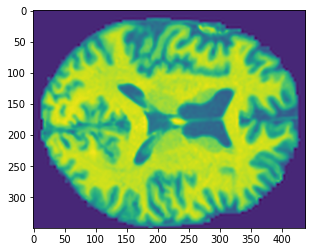

In [260]:
sample = ds_val[1400]
plt.imshow(sample['data'][0].astype(np.float32))
print(sample['label'][0])

In [261]:
y = model(torch.tensor(sample['data'][np.newaxis, ...]).float())
y = F.softmax(y, dim=1)
torch.argmax(y)*2.5+20

tensor(62.5000)

In [262]:
print(model.net)

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [263]:
class GradCam(torch.nn.Module):
    def __init__(self):
        super(GradCam, self).__init__()
        model = AgeModel2DSlices.load_from_checkpoint(ckpt, train_ds=None, val_ds=None)
        self.features_conv = torch.nn.Sequential(*list(model.net.children())[:-2])
        self.avgpool = model.net.avgpool
        self.fc = model.net.fc
        self.gradients = None
    
    def activations_hook(self, grad):
        self.gradients = grad
    
    def forward(self, x):
        y = self.features_conv(x)

        # register the hook
        h = y.register_hook(self.activations_hook)

        y = self.avgpool(y)
        y = y.view((1, -1))
        y = self.fc(y)
        y = F.softmax(y, dim=1)
        return y

    def get_activations_gradient(self):
        return self.gradients
    
    def get_activations(self, x):
        return self.features_conv(x)

In [264]:
cam = GradCam()
cam.eval()



GradCam(
  (features_conv): Sequential(
    (0): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats

In [265]:
input = torch.tensor(sample['data'][np.newaxis, ...]).float()

In [266]:
pred = cam(input)
cl = torch.argmax(pred)
print(f'prediction {cl*2.5+20}')
print(pred.shape)
print(cl)

prediction 62.5
torch.Size([1, 24])
tensor(17)


In [267]:
pred[:,cl].backward()
gradients = cam.get_activations_gradient()

In [268]:
pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])
activations = cam.get_activations(input).detach()
# weight the channels by corresponding gradients
for i in range(512):
    activations[:, i, :, :] *= pooled_gradients[i]
# average the channels of the activations
heatmap = torch.mean(activations, dim=1).squeeze()
# normalize the heatmap
heatmap /= torch.max(heatmap)


torch.Size([11, 14])


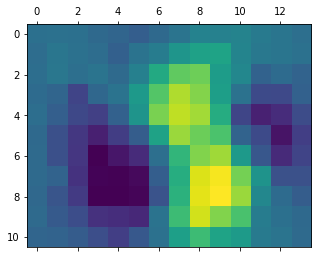

In [269]:
# draw the heatmap
plt.matshow(heatmap.squeeze())
print(heatmap.squeeze().shape)

In [270]:
import scipy.ndimage
hmap = heatmap.squeeze().numpy()
img = sample['data'][0]
zoom = np.array(img.shape)/np.array(hmap.shape)
hmap_zoomed = scipy.ndimage.zoom(hmap, zoom)
hmap_zoomed.shape

(350, 438)

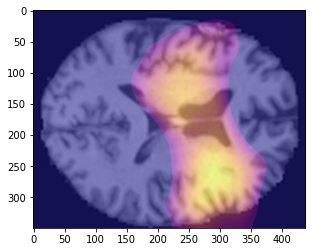

In [273]:
plt.imshow(img, cmap='gray')
hmap_filtered = np.copy(hmap_zoomed)
hmap_filtered[hmap_filtered < 0.2] = 0
plt.imshow(hmap_filtered, alpha=0.5, cmap='plasma')

(array([ 256.,  363.,  466.,  532., 1174., 2196., 1717., 1492., 1617.,
         879.]),
 array([20. , 25.2, 30.4, 35.6, 40.8, 46. , 51.2, 56.4, 61.6, 66.8, 72. ]),
 <a list of 10 Patch objects>)

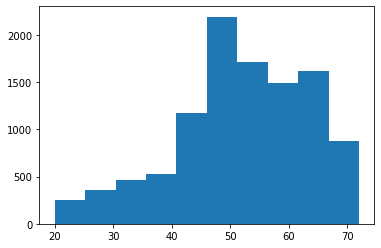

In [246]:
plt.hist(info_df['age'])

(array([ 56.,  69., 101.,  99., 250., 434., 308., 306., 314., 202.]),
 array([20. , 25.2, 30.4, 35.6, 40.8, 46. , 51.2, 56.4, 61.6, 66.8, 72. ]),
 <a list of 10 Patch objects>)

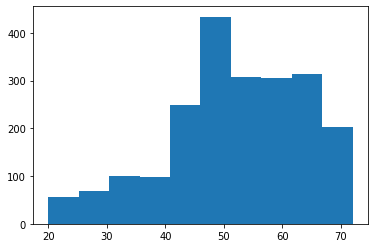

In [51]:
plt.hist(info_val['age'])